## Task 1 

### Find the primes numbers

Given a positive integer and an list of prime numbers, look for the two prime numbers, that sum the positive number. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case 


def find_the_primes_numbers (int:number_1, list[int] ,number_2):
     “””
 number_1 : integer value that is the positive number to decompose,
number_2 : integer list that has two prime numbers to add to obtain number_1.
Return the number_a and number_b
     “””

     # use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc. 

      # consider print your quantum circuit,


Example:

 > A = find_the_primes_numbers (18,[1,3,5,7,11,13,15])

print(A)

> “5,13”


## Solution

The task requires us to carry out three essential operations:

 - Creating pairs of all the numbers in the list of which there are $^nC_2$ (where n is the length of the list of numbers).
 - Calculating the sum of each pair.
 - Comparing the sum of each pair to N (target).

This approach would require $^nC_2$ quantum circuits. I have developed a solution that only uses $n$ quantum circuits. My solution makes use of three important concepts :
- *Superposition*
- *Quantum Fourier Transform*
- *Grover’s Algorithm*


### Outline of the solution

Let the list of prime numbers be $\text{prime\_list} = [X_0,X_1,..,X_{n-1}]$ and $N$ be the number we want to find (target). 

1. State Preparation
   
   Convert the integers in the list into binary; now, it is possible to encode this string into a quantum state. This type of encoding is called Basis encoding. But we don't directly use Basis encoding, and we create a superposition of these integer states.
   
   For example, $5$  is encoded as $|101\rangle$ and the list $[2,3]$ is encoded as $$|\psi_a\rangle = \frac{1}{\sqrt{2}}(|10\rangle+|11\rangle).$$
   
   Also, encode one of the numbers from $\text{prime\_list}$ using basis encoding in another register. Let $|\psi_a\rangle$ be the superposition state and $|\psi_b\rangle$ the second state. $a$ is a list, whereas $b$ is one of the elements of that list.
   Therefore,

   $$|\psi_a\rangle = \frac{1}{\sqrt{n}}(|x_0\rangle+|x_1\rangle+..+|x_{n-1}\rangle)\tag{1}$$

   $$|\psi_b\rangle = |x_j\rangle \tag{2}$$

   $$|\psi_{ab}\rangle = |\psi_a\rangle|\psi_b\rangle \tag{3}$$

   here $x_i$ is the binary representation of $X_i$. Since we have $n$ numbers in the list, we will have $n$ distinct states for $|\psi_j\rangle$.

2. Addition

   Draper QFT adder is used for addition, which uses the Quantum Fourier Transform, an analog to the classical Fourier Transform. We implement the following operator,

   $$\text{ADD}\vert a \rangle \vert b \rangle \vert 0 \rangle = \vert a \rangle \vert b \rangle \vert a+b \rangle \tag{4}.$$

   The adder converts the states into the Fourier basis and then uses controlled phase gates (CRZ gate) to induce a phase on the solution register. When QFT is applied again, we get the state with the sum in the solution register. Applying the QFT Adder, we get,

   $$ \text{ADD }|\psi_a\rangle |\psi_b\rangle |\psi_{sol}\rangle = |\psi_a\rangle |\psi_b\rangle |\psi_{a+b}\rangle. \tag{5}  $$

   The point to note is that $|\psi_a\rangle$ is a superposition state, and hence the $|\psi_{a+b}\rangle$ will consist of the sum of individual elements of $\text{prime\_list}$ and $b$.

3. Grover search

   Once we have the sums in $|\psi_{sol}\rangle$ we need to check if any of the multiple entries is equal to $N$, our target. For this, we use the Grover algorithm for searching $N$ out of $n$ entries. Grover Algorithm works by marking the desired state and then applying a diffusion operator so that the marked state has its amplitude amplified. Marking of the state is usually carried by an oracle such that,

   $$
   \begin{aligned}
   O_{\alpha }|x\rangle =-|x\rangle &{\text{for }}x=\alpha {\text{, that is, }}f(x)=1,\\
   O_{\alpha }|x\rangle =|x\rangle &{\text{for }}x\neq \alpha {\text{, that is, }}f(x)=0.
   \end{aligned}
   \tag{6}
   $$
   There can be more than a single solution, but all the sums in $|\psi_{a+b}\rangle$ are unique as the elements in $\text{prime\_list}$ are considered unique. Therefore, there will be a solution we need to search for. We only need a single iteration of the Grover Diffusion Operator for a single solution.

4. Post-Processing

    By measuring the probability $|\psi_{a}\rangle$, we can determine if any of the $n$ pairs give us our target. Since we only know the number encoded in $|\psi_{b}\rangle$, we only need to figure out the number with the highest probability in $|\psi_{a}\rangle$. The position in the array that contains the highest probability will be one of the numbers in the pair. We do this by comparing the individual probabilities by a threshold determined by $n$. 


This process is repeated as we cycle through every element in the list and encode it in $|\psi_{b}\rangle$. Therefore, we will get all possible pairs such that their sum adds up to the target. This solution also makes sure to get a pair like $(X_i, X_i)$.

In [1]:
# Installing required libraries.
# !pip install pennylane

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pennylane as qml

In [3]:
# Functions which will help in implementing the solution.

def list_state(N_QUBITS:int,prime_list:list,debug:bool=False):
    '''Function to convert a list of prime numbers to a quantum state.
    The statevector is made from the list by creating a superposition 
    of all the integers when converted using Basis encoding 
    (Eg. |3> -> |11> and |5> -> |101>).
    
    Eg. [1,2] -> [0,1/sqrt(2),1/sqrt(2),0]'''

    state = np.zeros(2**N_QUBITS)
    for i,_ in enumerate(state):
        if i in prime_list:
            state[i] = 1/np.sqrt(len(prime_list))
        else:
            state[i] = 0
    if debug:
        print(f'Qubits Required for {max(prime_list)} prime numbers: {N_QUBITS}')
        print(f'State:\n{state}') 

    return state

def plot_result(state:list):
    '''Function for plotting a list of probabilities obtained from 
    a quantum circuit.'''
    
    plt.figure(figsize=(7,4))
    plt.bar(range(len(state)),state)
    plt.xticks(range(len(state)+1))
    plt.xlabel('Integers')
    plt.ylabel('Probability')
    plt.show()
    return None

def add_fourier(d, wires_d):
    '''Function to add two integers using the Draper Adder.
    But the solution to the addition is stored in wires as this
    function add d to the state encoded in wires_d.'''

    for j in range(len(wires_d)):
        qml.RZ(d * np.pi / (2**j), wires=wires_d[j])

def add_ab(wires_a, wires_b, wires_sol):
    '''Function to add two integers using the Draper Adder.
    This function adds the two integers stored in wires_a and wires_b.
    The solution to addition is stored in wires_sol.'''

    # QFT on solution qubits
    qml.QFT(wires=wires_sol)

    # Add a to the counter
    for i in range(len(wires_a)):
        qml.ctrl(add_fourier, control=wires_a[i])(2 **(len(wires_a)-i-1), wires_sol)

    # Add b to the counter
    for i in range(len(wires_b)):
        qml.ctrl(add_fourier, control=wires_b[i])(2 **(len(wires_b)-i-1), wires_sol)

    # Returning to computational basis
    qml.adjoint(qml.QFT)(wires=wires_sol)

# Function to find the max number of qubits required to embed an integer
max_qubits = lambda a: len(bin(a)[2:])

In [4]:
def find_prime_pairs(N:int,prime_list:list,plot:bool=False,draw_circ:bool=False):

    # Max number of qubits required to store ab and the solution
    qubits_ab = max_qubits(max(prime_list))
    qubits_sol = max(max_qubits(N),qubits_ab) 

    # Total number of wires in circuit
    n_wires = 2*qubits_ab + qubits_sol

    # Creating the wires for the circuit
    wires_a = list(range(qubits_ab))
    wires_b = list(range(qubits_ab,2*qubits_ab))
    wires_sol = list(range(2*qubits_ab,2*qubits_ab+qubits_sol))

    dev = qml.device("default.qubit", wires=n_wires)
    @qml.qnode(dev)
    def sum(state:list, b:int):

        # Embedding the supperposition state and the interger b.
        qml.StatePrep(state=state, wires=wires_a)
        qml.BasisEmbedding(b, wires=wires_b)

        # Draper QFT adder
        add_ab(wires_a=wires_a, wires_b=wires_b, wires_sol=wires_sol)

        # Marking the answer (N) if it exists.
        qml.FlipSign(N, wires=wires_sol)

        # Undoing the addition.
        qml.adjoint(add_ab)(wires_a=wires_a, wires_b=wires_b, wires_sol=wires_sol) 
        
        # Grover Diffusion Operator.
        qml.GroverOperator(wires=wires_a)

        # Returning the Probability for superpositon state.
        return qml.probs(wires_a) 
    
    # Creating the supoerposition state and determing the threshold.
    state = list_state(qubits_ab,prime_list)
    prob_thresold = max(state)**2

    # Option to draw the circuit.
    if draw_circ:
        qml.draw_mpl(sum)(state,1)

    prime_pairs = []

    # Looping through all the numbers in the list
    for prime in prime_list:
        result = sum(state,prime)
        for ind,prob in enumerate(result):
            # Checking if the probability is greater than the threshold 
            if  prob > prob_thresold:
                prime_pairs.append((prime,ind))
                print(f'Found a sum. Prime pair: {prime_pairs[-1]}')
                if plot:
                    plot_result(result)
    
    # Checking if found pairs
    if len(prime_pairs) == 0:
        print(f'No prime pairs found.')
        return None
    
    # Removing duplicates
    unique_prime_pairs = list(set(tuple(sorted(pair)) for pair in prime_pairs))
    print(f'\nUnique Prime pairs:\n{unique_prime_pairs}')

    return unique_prime_pairs

In [5]:
find_prime_pairs(N=9,prime_list=[2, 3, 5]);

No prime pairs found.


In [6]:
find_prime_pairs(N=18,prime_list=[2, 3, 5, 7, 11]);

Found a sum. Prime pair: (7, 11)
Found a sum. Prime pair: (11, 7)

Unique Prime pairs:
[(7, 11)]


Found a sum. Prime pair: (17, 17)


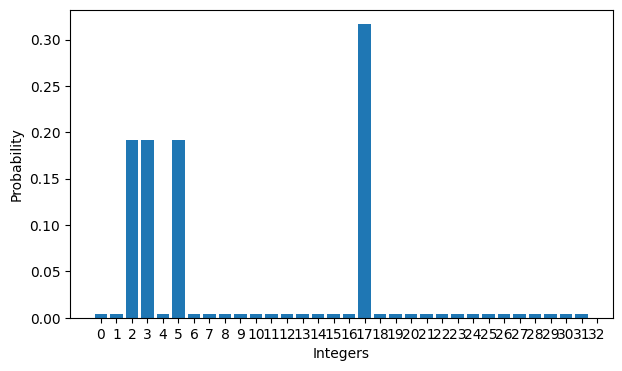


Unique Prime pairs:
[(17, 17)]


In [7]:
# We can plot the result state by setting the plot = 1
find_prime_pairs(N=34,prime_list=[2, 3, 5, 17],plot=True);

Found a sum. Prime pair: (3, 5)
Found a sum. Prime pair: (5, 3)

Unique Prime pairs:
[(3, 5)]


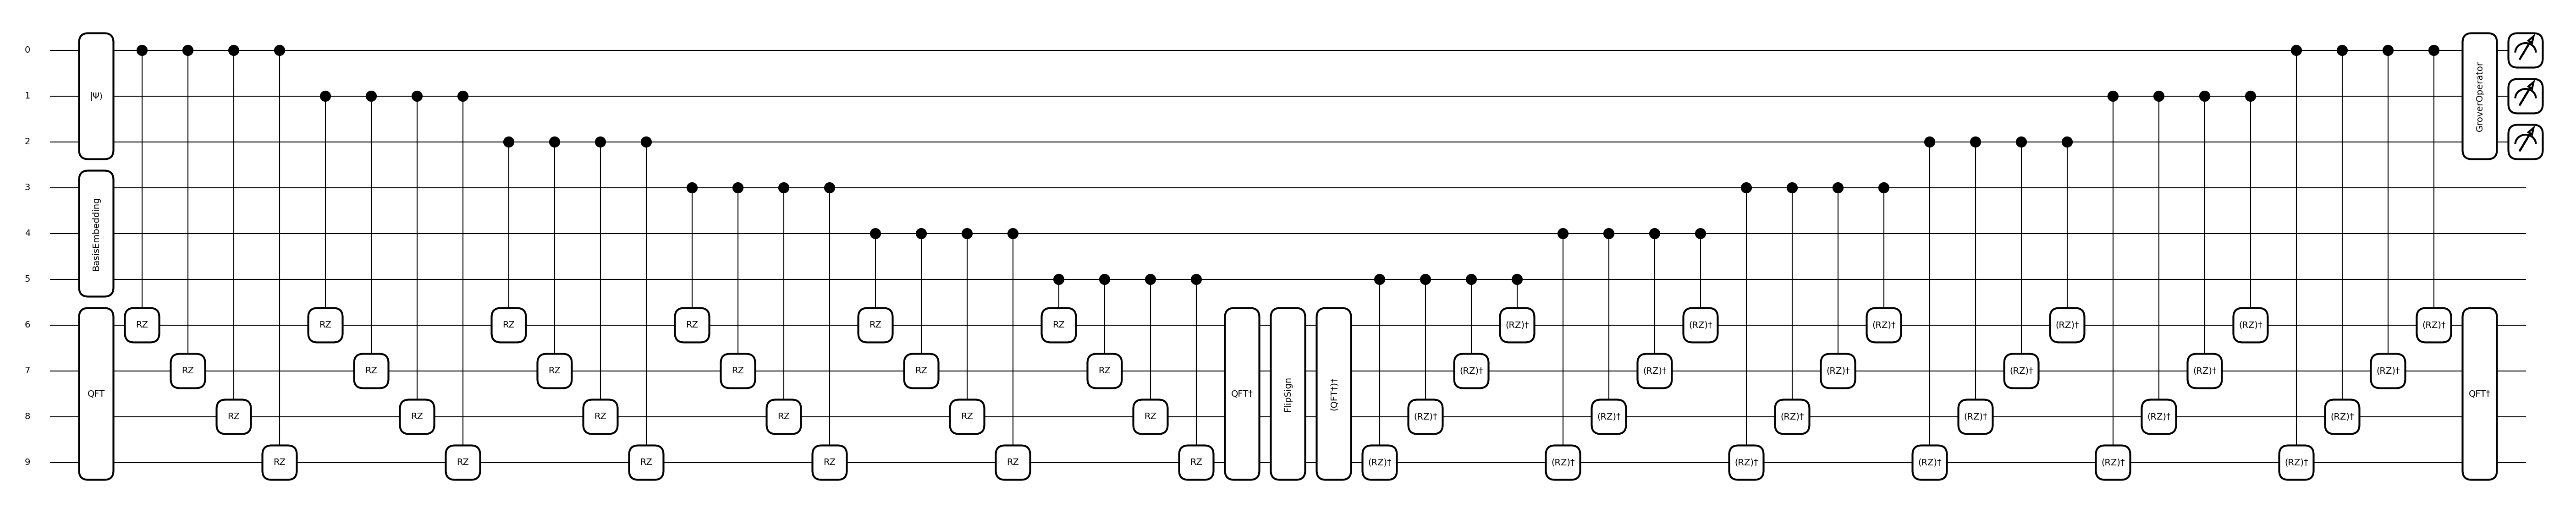

In [8]:
# Circuit can be printed by setting the draw_circ = True
find_prime_pairs(N=8,prime_list=[2, 3, 5, 7],draw_circ=True);